In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation, metrics


from imblearn.over_sampling import ADASYN


import seaborn as sns
import xgboost


from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("credit_train.csv", sep = ";", encoding='cp1251')
test = pd.read_csv("credit_test.csv", sep = ";", encoding='cp1251')

In [3]:
train.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170746 non-null int64
marital_status          170746 non-null object
job_position            170746 non-null object
credit_sum              170746 non-null object
credit_month            170746 non-null int64
tariff_id               170746 non-null float64
score_shk               170746 non-null object
education               170746 non-null object
living_region           170554 non-null object
monthly_income          170745 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(4), int64(4), object(7)
memory usage: 19.5+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91940 entries, 0 to 91939
Data columns (total 14 columns):
client_id               91940 non-null int64
gender                  91940 non-null object
age                     91940 non-null int64
marital_status          91940 non-null object
job_position            91940 non-null object
credit_sum              91940 non-null object
credit_month            91940 non-null int64
tariff_id               91940 non-null float64
score_shk               91940 non-null object
education               91940 non-null object
living_region           91824 non-null object
monthly_income          91940 non-null int64
credit_count            87237 non-null float64
overdue_credit_count    87237 non-null float64
dtypes: float64(3), int64(4), object(7)
memory usage: 9.8+ MB


In [6]:
y = train['open_account_flg']

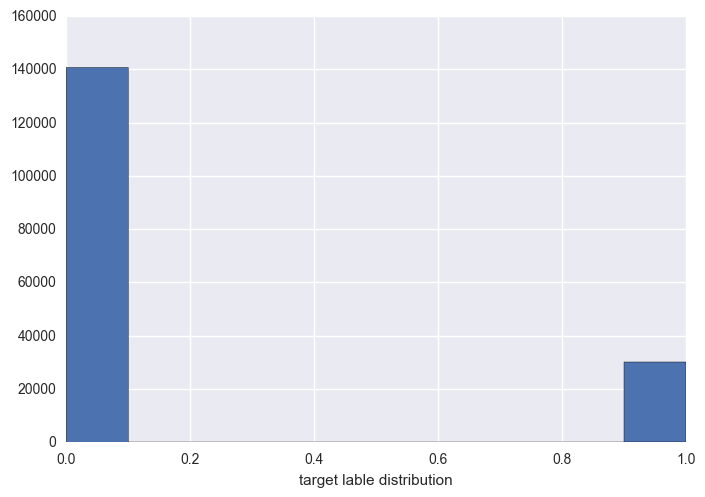

In [7]:
### посмотрим распределение целевой метки в train. Видим, что отношение между классами несбалансированное
y.hist()
plt.xlabel("target lable distribution")

In [8]:
train.gender = train.gender.map({"M":1, "F":0})
test.gender = test.gender.map({"M":1, "F":0})

In [9]:
train.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,1,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,0,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,1,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,0,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,1,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [10]:
train.rename(columns={"open_account_flg":"target"}, inplace=True)

In [11]:
train_col = train.columns.drop("target")

I кодировка категориальных признаков, кроме living region

In [12]:
dummy_df = pd.concat([train[train_col], test], axis=0)

In [13]:
dummy_df.shape

(262686, 14)

In [14]:
dummy_df = pd.get_dummies(dummy_df, columns=["education","job_position", "marital_status"], drop_first=True)

In [15]:
train = dummy_df[:train.shape[0]]
test = dummy_df[train.shape[0]:]

In [16]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 170745
Data columns (total 36 columns):
client_id               170746 non-null int64
gender                  170746 non-null int64
age                     170746 non-null int64
credit_sum              170746 non-null object
credit_month            170746 non-null int64
tariff_id               170746 non-null float64
score_shk               170746 non-null object
living_region           170554 non-null object
monthly_income          170745 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
education_GRD           170746 non-null uint8
education_PGR           170746 non-null uint8
education_SCH           170746 non-null uint8
education_UGR           170746 non-null uint8
job_position_BIS        170746 non-null uint8
job_position_BIU        170746 non-null uint8
job_position_DIR        170746 non-null uint8
job_position_HSK        170746 non-null uint8
job_

II кодировка региона через среднюю зарплату

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

In [ ]:
train['monthly_income'] = train['monthly_income'].astype(float)
test['monthly_income'] = test['monthly_income'].astype(float)

train["city_mean_income"] = code_mean(train, 'living_region', 'monthly_income')
train.drop("living_region", axis=1, inplace=True)

test["city_mean_income"] = code_mean(test, 'living_region', 'monthly_income')
test.drop("living_region", axis=1, inplace=True)

IV Генерация данных о зарплате и выплатам по кредиту

In [ ]:
train['credit_sum'] = train['credit_sum'].apply(lambda x: x.replace(",","."))
test['credit_sum'] = test['credit_sum'].apply(lambda x: x.replace(",","."))

train['credit_sum'] = train['credit_sum'].astype(float)
test['credit_sum'] = test['credit_sum'].astype(float)

In [ ]:
train["credit_pay"] = train["credit_sum"] / train["credit_month"]
train["money_for_life"] = train["monthly_income"] - train["credit_pay"]
train["dif_city"] = train["monthly_income"] - train["city_mean_income"]

test["credit_pay"] = test["credit_sum"] / test["credit_month"]
test["money_for_life"] = test["monthly_income"] - test["credit_pay"]
test["dif_city"] = test["monthly_income"] - test["city_mean_income"]

V анализ score_shk

In [ ]:
train['score_shk'] = train['score_shk'].apply(lambda x: x.replace(",","."))
test['score_shk'] = test['score_shk'].apply(lambda x: x.replace(",","."))

train['score_shk'] = train['score_shk'].astype(float)
test['score_shk'] = test['score_shk'].astype(float)

VI ADASYN для оверсэмплинга

In [17]:
train.columns

Index([u'client_id', u'gender', u'age', u'credit_sum', u'credit_month',
       u'tariff_id', u'score_shk', u'living_region', u'monthly_income',
       u'credit_count', u'overdue_credit_count', u'education_GRD',
       u'education_PGR', u'education_SCH', u'education_UGR',
       u'job_position_BIS', u'job_position_BIU', u'job_position_DIR',
       u'job_position_HSK', u'job_position_INP', u'job_position_INV',
       u'job_position_NOR', u'job_position_ONB', u'job_position_PNA',
       u'job_position_PNI', u'job_position_PNS', u'job_position_PNV',
       u'job_position_SPC', u'job_position_UMN', u'job_position_WOI',
       u'job_position_WRK', u'job_position_WRP', u'marital_status_DIV',
       u'marital_status_MAR', u'marital_status_UNM', u'marital_status_WID'],
      dtype='object')

In [22]:
tmp = train.drop([u'client_id', u'gender', u'age', u'credit_sum', u'credit_month',
       u'tariff_id', u'score_shk', u'living_region', u'monthly_income',
       u'credit_count', u'overdue_credit_count'], axis = 1)

In [ ]:
train.head()

In [ ]:
ada = ADASYN(n_jobs=-1)
X_resampled, y_resampled = ada.fit_sample(tmp, y)

In [ ]:
train['target'] = y

In [ ]:
train.to_csv("train_random_oversampling.csv", columns=train.columns, index=False)
test.to_csv("test.csv", columns=test.columns, index=False)